In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model,layers, regularizers

import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt

# Constructing GAN
## Define loss
* Wasserstein loss
* JS divergence

In [ ]:
generator_encoded=keras.models.load_model("drive/MyDrive/GAN/generator_encoded_epoch300")
discriminator=keras.models.load_model("drive/MyDrive/GAN/discriminator_epoch300")

In [ ]:
wasserstein=True
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
if wasserstein==False:
    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output) # sum over reals -real*log(P(real)) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)# sum over fakes -log(1-Preal)
        total_loss = real_loss + fake_loss
        return total_loss
    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output) #  sum over fakes - log(Preal)
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)
else:
    def discriminator_loss(real_output, fake_output):
        real_loss = -tf.reduce_mean(real_output)    #
        fake_loss = tf.reduce_mean(fake_output) #smaller 
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(fake_output):
        return -tf.reduce_mean(fake_output)
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)


## Generator

In [54]:
#generator is our generator model
def make_generator(n_output, n_input = 100, hidden_widths = [128,128,128],minibatch_avg=True):
    ''' Make generator for data of data_dim number of fields. The input_dim represents the noise but could be used for style transfer.
    gen_hidden_widths are the widths of the hidden layers of the nn'''
    gen_input_layer = layers.Input(shape=(n_input,),name="GeneratorInput")
    gen_input_batch_norm=layers.BatchNormalization(name="GenBNInput")(gen_input_layer)


    gen_hidden_layers=[layers.Dense(units=hidden_widths[0],activation=tf.nn.relu,name="GenHiddenLayer0")(gen_input_batch_norm)]

    for i in range(1,len(hidden_widths)):
        gen_hidden_layers=gen_hidden_layers+[layers.BatchNormalization(name="GenBNLayer"+str(i))(gen_hidden_layers[-1])]
        gen_hidden_layers=gen_hidden_layers+[layers.Dense(units=hidden_widths[i],activation=tf.nn.leaky_relu,
                                                          name="GenHiddenLayer"+str(i))(gen_hidden_layers[-1])]
        gen_hidden_layers=gen_hidden_layers+\
        [layers.Add(name="GenSkipLayer"+str(i))((gen_hidden_layers[-1],gen_hidden_layers[-3]))]


    gen_output=layers.Dense(units=n_output,activation=tf.keras.activations.linear,
                                                          name="GenOutput")(gen_hidden_layers[-1])
    if(minibatch_avg):
        gen_output_avg=tf.reduce_mean(gen_output,axis=0,keepdims=True,name="GenOutputAverage")*\
        tf.ones(shape=tf.shape(gen_output))

        generator=keras.Model(
            inputs=[gen_input_layer],
            outputs=[gen_output,gen_output_avg],
        )
        return generator
    else:
        generator=keras.Model(
            inputs=[gen_input_layer],
            outputs=[gen_output],
        )
        return generator
        



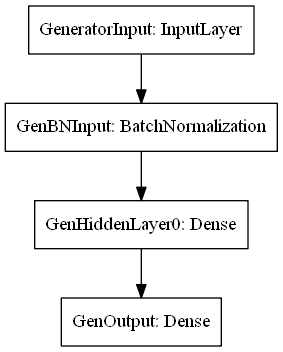

In [56]:
generator = make_generator(n_output = 1,n_input = 100, hidden_widths=[128])
keras.utils.plot_model(generator, "images/generator_test0.png")
generator1 = make_generator(n_output = 1,n_input = 100, hidden_widths=[128],minibatch_avg=False)
keras.utils.plot_model(generator1, "images/generator_test1.png")

## Discriminator

In [47]:
disc_hidden_widths=[128,256,256]
def make_discriminator(n_input, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=True):
    if minibatch_avg:
        disc_input_layer=layers.Input(shape=(n_input,),name="DiscriminatorInput")
        disc_avg_input_layer=layers.Input(shape=(n_input,),name="DiscriminatorAverageInput")
        disc_allinput=layers.Concatenate(name="DiscriminatorAllInput")((disc_input_layer,
                                                                                    disc_avg_input_layer,
                                                                                   ))
    else:
        disc_allinput=layers.Input(shape=(n_input,),name="DiscriminatorAllInput")
    
    disc_hidden_layers=[layers.Dense(units=disc_hidden_widths[0],activation=tf.nn.leaky_relu,name="DiscHiddenLayer0")(disc_allinput)]

    for i in range(1,len(disc_hidden_widths)):
        disc_hidden_layers=disc_hidden_layers+\
        [layers.Dense(units=disc_hidden_widths[i],activation=tf.nn.leaky_relu,name="DiscHiddenLayer"+str(i))(disc_hidden_layers[-1])]
    if gan_type=="JS":
        disc_output=layers.Dense(units=1,activation=tf.nn.sigmoid,name="DiscriminatorOutput")(disc_hidden_layers[-1])
    if gan_type=="W":
        disc_output=layers.Dense(units=1,activation=tf.keras.activations.linear,name="DiscriminatorOutput")(disc_hidden_layers[-1])
    
    if minibatch_avg:
        discriminator=keras.Model(
            inputs=[disc_input_layer,disc_avg_input_layer],
            outputs=[disc_output]
        )
        return discriminator
    else:
        discriminator=keras.Model(
            inputs=disc_allinput,
            outputs=[disc_output]
        )
        return discriminator
        

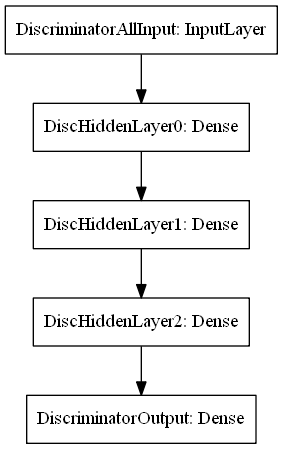

In [50]:
discriminator = make_discriminator(n_input=10, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=True)
keras.utils.plot_model(discriminator, "images/discriminator_test0.png")
discriminator1 = make_discriminator(n_input=10, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=False)
keras.utils.plot_model(discriminator1, "images/discriminator_test1.png")

# Training loop for Generator Discriminator pair

In [ ]:
# THIS APPLIES GRADIENT PENALTY THE OTHER ONE DOESN'T
#@tf.function 
def train_step(latent_data,step,GP_rate):
    batch_shape=tf.shape(latent_data)
    noise = tf.random.normal([batch_shape[0], noise_dim])
    
    uniform_rand = tf.random.uniform(shape=batch_shape, maxval=1)
    mask_fake = uniform_rand #tf.math.greater(.5, uniform_rand)
    mask_fake = tf.cast(mask_fake,"float32")
    mask_real = (1.-mask_fake)

    for d_train_i in range(5):
        with tf.GradientTape() as disc_tape:
            generated_data = generator_encoded(noise,training=True)
            latent_avg = tf.reduce_mean(latent_data,axis = 0)*\
            tf.ones(shape = np.shape(latent_data),dtype = "float32")
            fake_output = discriminator(generated_data, training=True)
            real_output = discriminator((latent_data,latent_avg), training=True)
            gen_loss = generator_loss(fake_output)
            
            mixed_real_fake = (mask_fake*generated_data[0] + mask_real*latent_data,\
                               mask_fake*generated_data[1] + mask_real*latent_avg)
            with tf.GradientTape() as g:
                g.watch(mixed_real_fake)
                y = discriminator(mixed_real_fake)
            disc_gradient = g.gradient(y, mixed_real_fake)
            gradient_penalty = tf.reduce_mean(tf.square(
                tf.sqrt(tf.reduce_sum(tf.square(tf.concat(disc_gradient,axis=1)),axis=1))\
                - tf.ones(shape=(batch_shape[0],1))))
            
            disc_loss = discriminator_loss(real_output, fake_output) + GP_rate*gradient_penalty
            #print(gradient_penalty)
        
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    for g_train_i in range(1):
        with tf.GradientTape() as gen_tape:
            generated_data = generator_encoded(noise,training=True)
            latent_avg = tf.reduce_mean(latent_data,axis = 0)*\
            tf.ones(shape = np.shape(latent_data),dtype = "float32")

            fake_output = discriminator(generated_data, training=True)
            real_output = discriminator((latent_data,latent_avg), training=True)
            gen_loss = generator_loss(fake_output)
            #disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator_encoded.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_encoded.trainable_variables))
    return float(gen_loss),float(disc_loss)

# Training
## train the autoencoder

In [ ]:

epoch=0
generator_encoded.save('generator_encoded'+str(epoch))
discriminator.save('discriminator'+str(epoch))

In [ ]:
noise_dim=100
SAMPLE_NOISE=tf.random.normal([50000, noise_dim])
def train(data_batches,epochs,GP_rate,start_epoch):
    for epoch in range(epochs):
        start = time.time()
        for step,data_batch in enumerate(data_batches):
            gen_loss,disc_loss=train_step(data_batch,step,GP_rate)
        print("Generator Loss ",gen_loss,"Discriminator Loss ",disc_loss)


        #Visualization
        g_test=generator_encoded(tf.constant(SAMPLE_NOISE,dtype="float32"))[0].numpy()
        
        if epoch % 5==0:
            f,ax=plt.subplots(2,2,figsize=(10,10))
            for i in range(n_compression-1):
                ax[i % 2,int(np.floor(i/2))].scatter(latent_data[:10000,i],latent_data[:10000,i+1],alpha=.1,label="Real Data")
                ax[i % 2,int(np.floor(i/2))].scatter(g_test[:10000,i],g_test[:10000,i+1],color="magenta",s=1,label="Synthetic Data")
                ax[i % 2,int(np.floor(i/2))].set_xlim(np.min(latent_data[:1000,i]),np.max(latent_data[:1000,i]))
                ax[i % 2,int(np.floor(i/2))].set_ylim(np.min(latent_data[:1000,i+1]),np.max(latent_data[:1000,i+1]))
            ax[i % 2,int(np.floor(i/2))].legend()
            f.tight_layout()
            f.subplots_adjust(top=0.95)
            f.suptitle("Latent Space",fontsize=20)
            
            plt.savefig("drive/MyDrive/GAN/latent_anim/latent_epoch"+str(start_epoch+epoch)+".png")
        if epoch % 20==0:
            synthetic_data=\
            decoder.predict(g_test)
            synthetic_data1=array_to_data(synthetic_data[0],synthetic_data[1],
            np.max(cont_data,axis=0),
            np.min(cont_data,axis=0))
            synth_continuous=synthetic_data1[0]
            synth_binary=synthetic_data1[1]

            f,ax=plt.subplots(1,2,figsize=(20,5))
            ax[0].set_title("Synthetic Data",fontsize=20)
            ax[0].hist(synth_continuous[(synth_binary[:,2]==1)&(synth_binary[:,0]==0),0],bins=100)
            ax[0].hist(synth_continuous[(synth_binary[:,2]==1)&(synth_binary[:,0]==1),0],bins=100)
            ax[0].set_xlabel("Age",fontsize=20)

            ax[1].set_title("Real Data",fontsize=20)
            cont_df[(binary_df.GENDER==False)&(binary_df.death)].Age.plot(kind="hist",bins=100,ax=ax[1],label="Male")
            cont_df[(binary_df.GENDER)&(binary_df.death)].Age.plot(kind="hist",bins=100,ax=ax[1],label="Female")
            ax[1].set_xlabel("Age",fontsize=20)
            f.suptitle("COVID-19 Mortality by Age and Gender",fontsize=20)
            f.savefig("drive/MyDrive/GAN/mortality_anim/mortality_epoch"+str(start_epoch+epoch)+".png")

        if epoch % 100==0:
            generator_encoded.save('drive/MyDrive/GAN/generator_encoded_epoch'+str(start_epoch+epoch))
            discriminator.save('drive/MyDrive/GAN/discriminator_epoch'+str(start_epoch+epoch))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
latent_data
generator_encoded(tf.constant(SAMPLE_NOISE,dtype="float32"))
generator_encoded(tf.constant(SAMPLE_NOISE,dtype="float32"))[0].numpy()

In [ ]:
latent_data

In [ ]:
#latent_data=latent_data.astype(np.float32)
latent_data=tf.random.shuffle(latent_data)
BUFFER_SIZE = 60000
BATCH_SIZE = 20000
EPOCHS=3
# Batch and shuffle the data
data_batches = tf.data.Dataset.from_tensor_slices(latent_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
n_compression

In [ ]:
latent_data

In [ ]:
synthetic_data1=array_to_data(synthetic_data[0],synthetic_data[1],
np.max(cont_data,axis=0),
np.min(cont_data,axis=0))
synthetic_data1[0]

In [ ]:
train(data_batches,900,10,start_epoch=2201)
import shutil
#for i in range(1200,1700):
#    if i % 5 ==0:
#        shutil.move("latent_epoch"+str(i)+".png","drive/MyDrive/GAN/latent_anim")
#    if i % 20 ==0:
#        shutil.move("mortality_epoch"+str(i)+".png","drive/MyDrive/GAN/mortality_anim")

In [ ]:
for i in range(300,400):
    if i % 5 ==0:
        shutil.move("latent_epoch"+str(i)+".png","drive/MyDrive/GAN/latent_anim")
    if i % 20 ==0:
        shutil.move("mortality_epoch"+str(i)+".png","drive/MyDrive/GAN/mortality_anim")

In [ ]:
synthetic_data=\
decoder.predict(generator_encoded(tf.constant(SAMPLE_NOISE,dtype="float32"))[0].numpy())
synthetic_data1=array_to_data(synthetic_data[0],synthetic_data[1],
np.max(cont_data,axis=0),
np.min(cont_data,axis=0))
synth_continuous=synthetic_data1[0]
synth_binary=synthetic_data1[1]
f,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].set_title("Synthetic Data",fontsize=20)
ax[0].hist(synth_continuous[(synth_binary[:,2]==1)&(synth_binary[:,0]==0),0],bins=100)
ax[0].hist(synth_continuous[(synth_binary[:,2]==1)&(synth_binary[:,0]==1),0],bins=100)
ax[0].set_xlabel("Age",fontsize=20)

ax[1].set_title("Real Data",fontsize=20)
cont_df[(binary_df.GENDER==False)&(binary_df.death)].Age.plot(kind="hist",bins=100,ax=ax[1],label="Male")
cont_df[(binary_df.GENDER)&(binary_df.death)].Age.plot(kind="hist",bins=100,ax=ax[1],label="Female")
ax[1].set_xlabel("Age",fontsize=20)
f.suptitle("COVID-19 Mortality by Age and Gender",fontsize=20)

# New section

In [ ]:
sample_noise=tf.random.normal([100000, NOISE_DIM])
g_test=generator_encoded(tf.constant(sample_noise,dtype="float32"))
plt.figure(figsize=(10,10))
pd.Series(g_test[0][g_test[0]>0].numpy().flatten()).plot(kind="hist",bins=200)
plt.figure(figsize=(10,10))
pd.Series(latent_data[:100000,:].flatten()).plot(kind="hist",bins=200)

In [ ]:
loaded_gen=keras.models.load_model('generator_encoded_epoch0')

In [ ]:
import imageio, glob
anim_file = 'drive/MyDrive/GAN/latent.gif'
i=0
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(\
                        'drive/MyDrive/GAN/latent_anim/latent_epoch*.png')
    filenames.sort(key=lambda x: int(x[len("drive/MyDrive/GAN/latent_anim/latent_epoch"):-4]))
    for filename in filenames:
        if (i<500)&(i%2==0):
            print(i)
            image = imageio.imread(filename)
            writer.append_data(image)
        i=i+1
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
list(map(lambda x: int(x[len("drive/MyDrive/GAN/latent_anim/latent_epoch"):-4]),filenames))



In [ ]:
filenames